# Анализ поведения клиентов сети фитнес-центров

<b> Описание проекта

Сеть фитнес-центров хочет провести анализ оттока клиентов и на основе этого разработать план действий по удержанию клиентов.
<p> «Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц.

<p><b>Задачи 

* спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
      1) выделить целевые группы клиентов;
      2) предложить меры по снижению оттока;
      3) определить другие особенности взаимодействия с клиентами

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
import itertools 
from sklearn.cluster import KMeans

 ## Загрузка данных и подготовка

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
print('Дубликаты:{:.0f}'.format(df.duplicated().sum()))
print('Пропуски')
df.isna().sum()

Дубликаты:0
Пропуски


gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [6]:
df['Month_to_end_contract'] = df['Month_to_end_contract'].astype(int)
df.columns = df.columns.str.lower()

## EDA

In [7]:
df.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [8]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [9]:
df.groupby('churn', as_index=False).mean()

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [10]:
df.groupby('churn', as_index=False).median()

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,1.0,1.0,1.0,0.0,1.0,6.0,0.0,30.0,149.881171,6.0,4.0,2.043252,2.046697
1,1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,27.0,103.814686,1.0,1.0,1.491187,0.979445


Столбчатые гистограммы и распределения признаков для тех, кто остался (не попали в отток) и  тех, кто ушёл (отток)

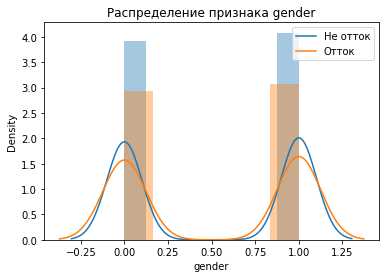

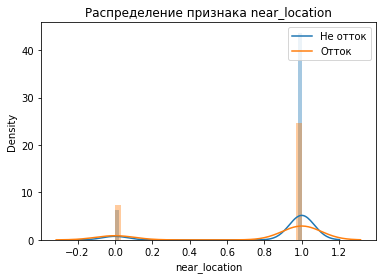

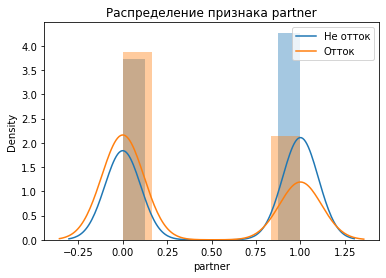

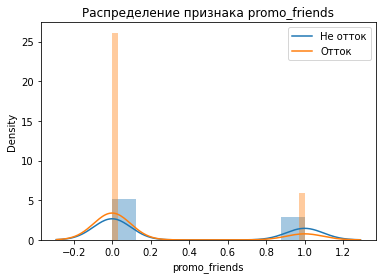

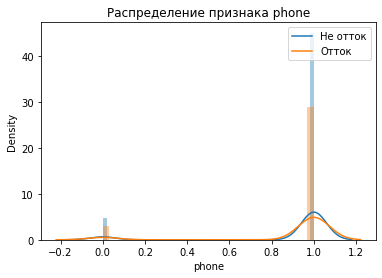

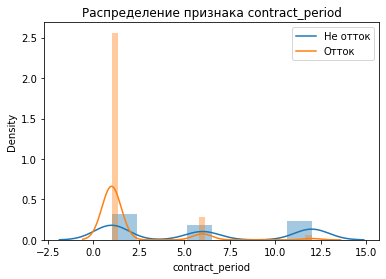

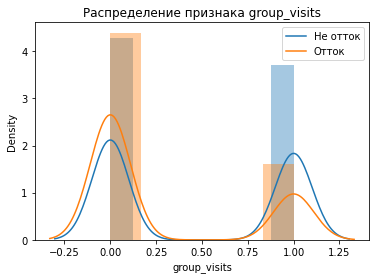

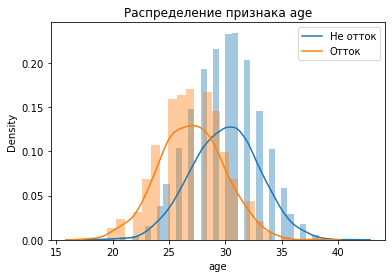

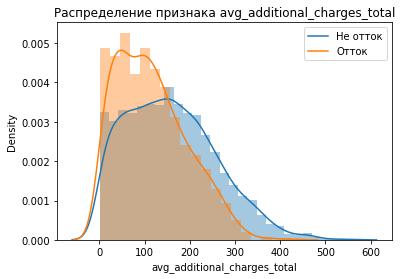

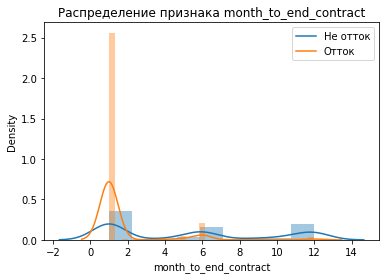

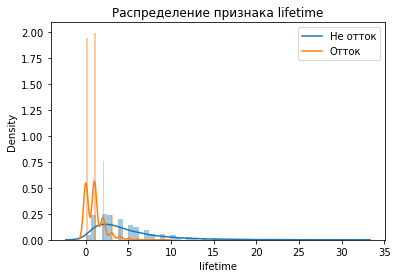

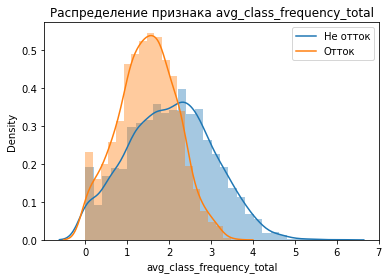

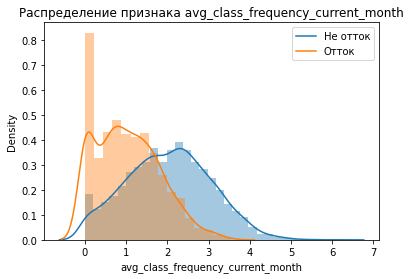

In [12]:
for column in df.drop('churn', axis = 1).columns:
    plt.subplots(1, 1, sharey=True)
    plt.title("Распределение признака "+column)
    sns.distplot(df.query('churn == 0')[column]) 
    sns.distplot(df.query('churn == 1')[column])
    plt.legend([df.query('churn == 0')[column], df.query('churn == 1')[column]], labels=["Не отток", "Отток"],
           loc="upper right")

### Матрица корреляций

In [13]:
df.corr()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


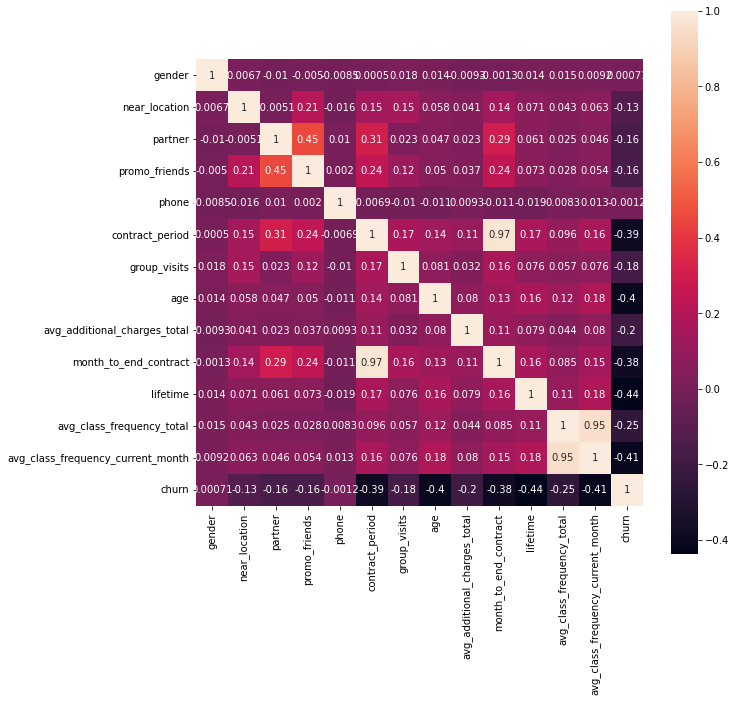

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, square=True)
plt.show()

<b>ВЫВОД:</b> Можно увидеть, что сильнее всего отток коррелирует с такими признаками как 'Contract_period', 'Age', 'Month_to_end_contract','lifetime','Avg_class_frequency_current_month'

### phik корреляция

Используем данную корреляцию поскольку в данных много категориальных признаков

In [15]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [17]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'churn']


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00
near_location,0.00,1.00,0.00,0.32,0.00,0.09,0.24,0.07,0.12,0.19,0.06,0.06,0.07,0.20
partner,0.00,0.00,1.00,0.65,0.00,0.19,0.02,0.06,0.03,0.39,0.10,0.00,0.02,0.24
promo_friends,0.00,0.32,0.65,1.00,0.00,0.15,0.19,0.06,0.07,0.33,0.10,0.04,0.06,0.25
phone,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00
contract_period,0.00,0.09,0.19,0.15,0.00,1.00,0.10,0.16,0.14,0.97,0.20,0.15,0.18,0.25
group_visits,0.01,0.24,0.02,0.19,0.00,0.10,1.00,0.09,0.05,0.22,0.10,0.07,0.09,0.27
age,0.00,0.07,0.06,0.06,0.00,0.16,0.09,1.00,0.08,0.13,0.16,0.15,0.21,0.52
avg_additional_charges_total,0.00,0.12,0.03,0.07,0.00,0.14,0.05,0.08,1.00,0.13,0.01,0.09,0.06,0.26
month_to_end_contract,0.00,0.19,0.39,0.33,0.00,0.97,0.22,0.13,0.13,1.00,0.23,0.18,0.19,0.52


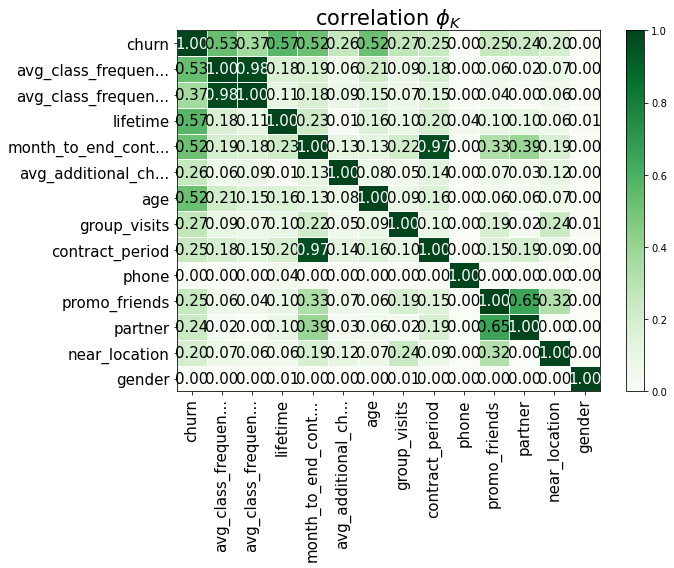

In [18]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

Данная корреляция показывает схожие выводы

Ниже можно увидеть как коррелируют признаки

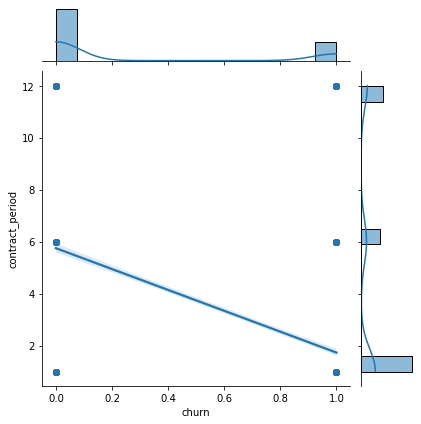

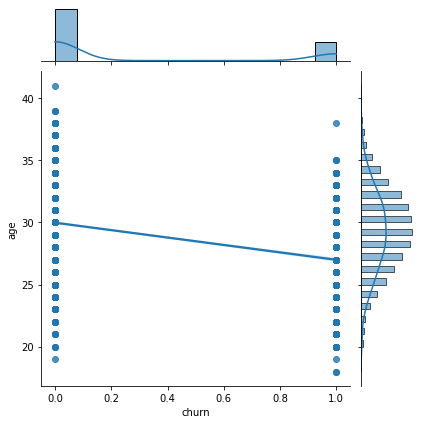

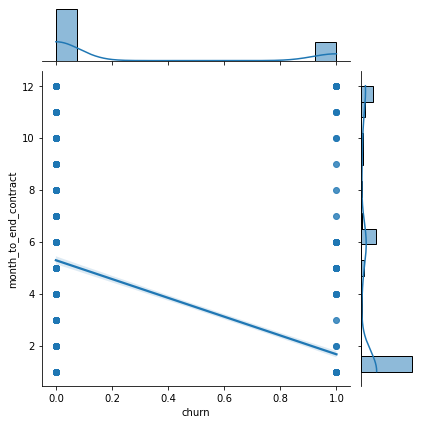

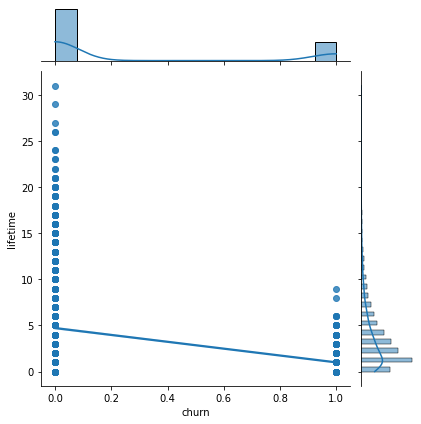

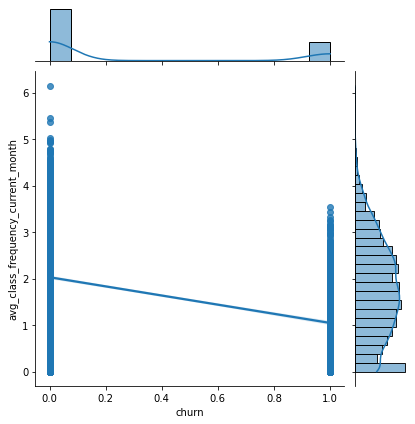

In [33]:
for i in ['contract_period', 'age', 'month_to_end_contract','lifetime','avg_class_frequency_current_month']:
    sns.jointplot(data=df, x="churn", y=i, kind="reg")

* Чем больше срок действующего абонемента, тем меньше вероятность оттока.
* Чем старше клиент, тем меньше вероятность оттока.
* Чем больше срок до окончание действия абонемента тем вероятность оттока меньше.
* Чем времени с момента первого обращения в фитнес-центр прошло больше, тем вероятность оттока меньше
* Чем чаще в среднем клиент ходит в фитнес-центр, тем вероятность оттока меньше

## Модель прогнозирования оттока клиентов

In [36]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'): # функция для вывода метрик
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

* Обучение логистической регрессией

In [37]:
X = df.drop('churn', axis = 1) # Матрица признаков
y = df['churn'] # Целевая переменная
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # Разделение на выборки

In [38]:
scaler = StandardScaler() # Стандартизируем данные
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [39]:
model_log = LogisticRegression(solver='liblinear', random_state=0) # Логистическая регрессия
model_log.fit(X_train_st, y_train)
predictions_log = model_log.predict(X_test_st) 
probabilities_log = model_log.predict_proba(X_test_st)[:,1] # прогноз вероятности

In [40]:
print_all_metrics(
    y_test,
    predictions_log,
    probabilities_log, 
    title='Метрики для модели логистической регрессии:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97


In [41]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # Модель случайного леса
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81
	F1: 0.83
	ROC_AUC: 0.97


<b>ВЫВОД:</b> Можно увидеть, что доля правильных ответов для обеих моделей одинаковая. Точность и полнота тоже близки. Но модель логистической регрессии показывает себя лучше.

## Кластеризация клиентов

* Стандартизация данных

In [42]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

* Матрица расстояний и дендрограмма

In [43]:
linked = linkage(X_sc, method = 'ward')

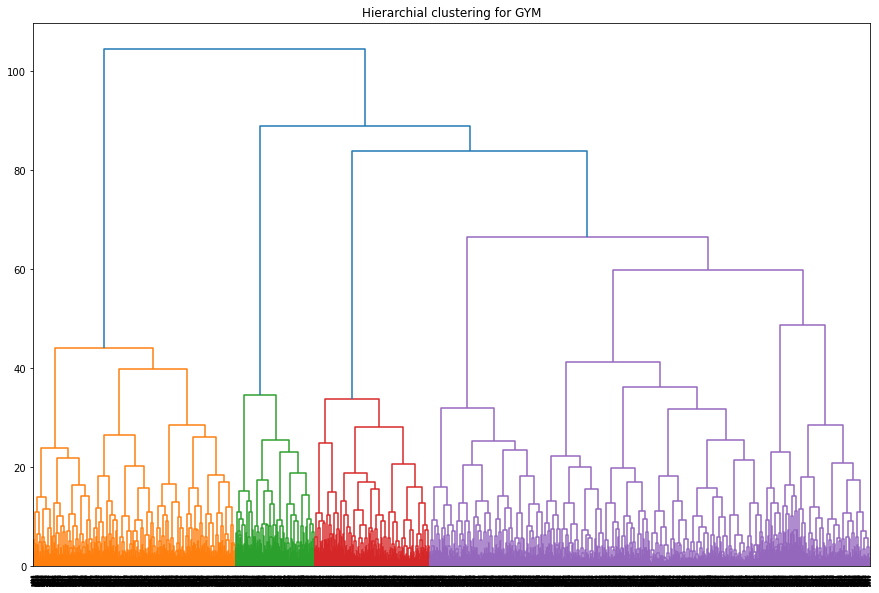

In [44]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

* Модель кластеризации на основании алгоритма K-Means 

In [45]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)
df['cluster_km'] = labels
df.groupby('cluster_km', as_index=False).mean()

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


* Распределение признаков по кластерам 

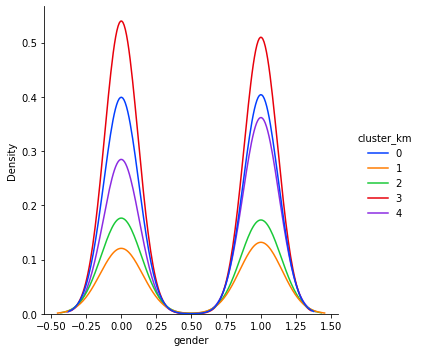

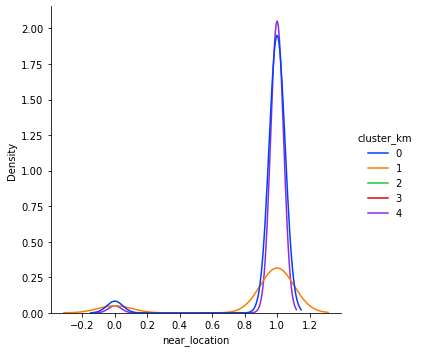

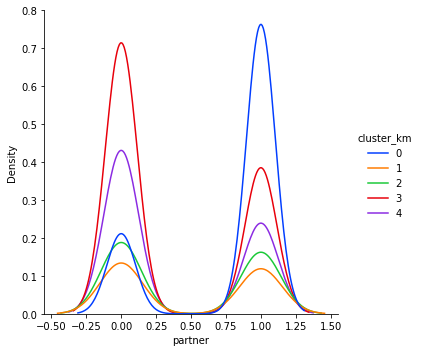

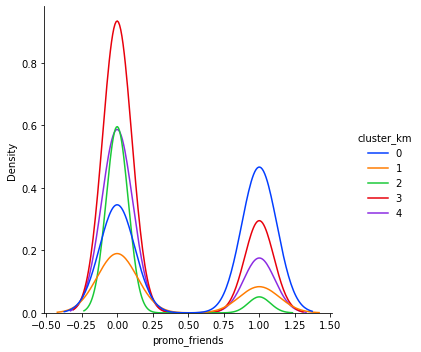

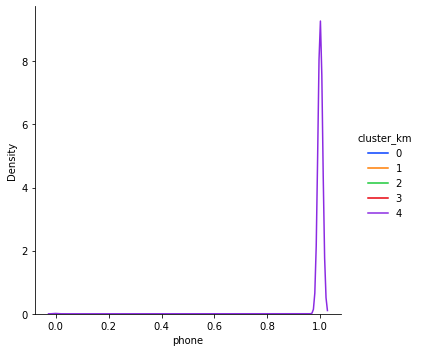

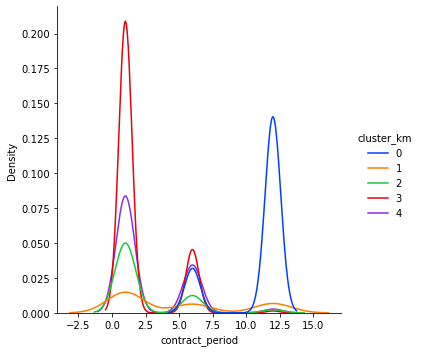

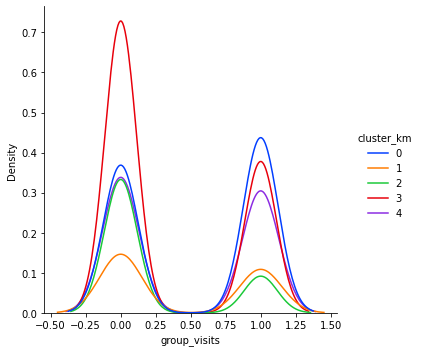

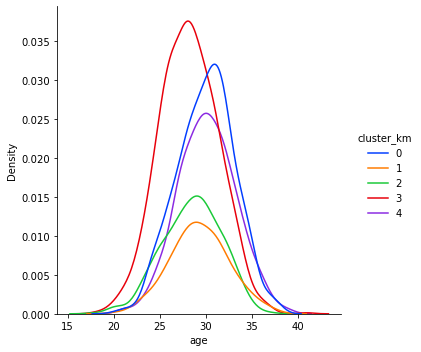

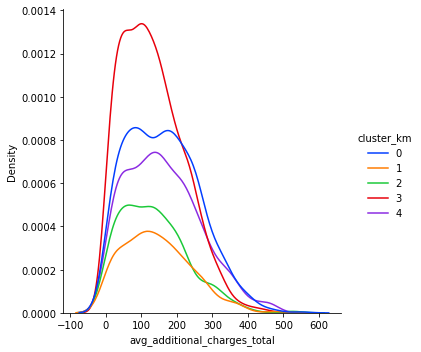

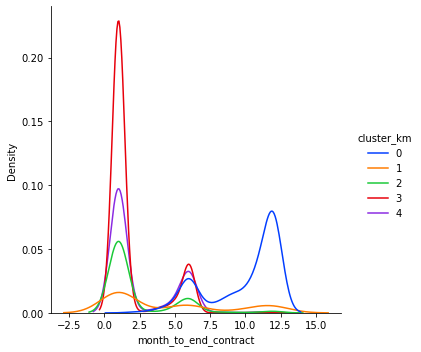

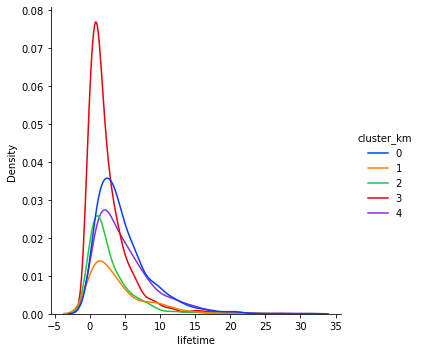

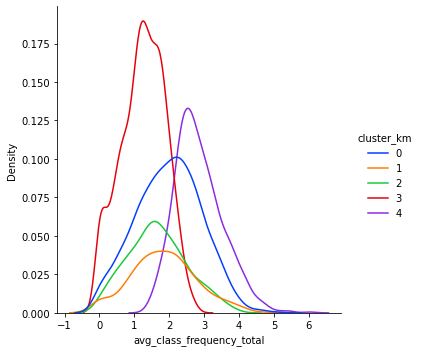

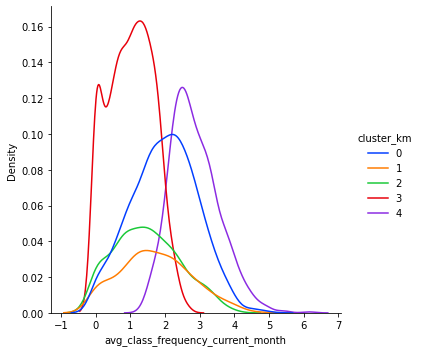

In [46]:
for i in df.drop(['cluster_km','churn'], axis=1).columns:
    sns.displot(df,x=i, hue='cluster_km',kind='kde', palette='bright'),
    plt.show()

In [47]:
df.groupby('cluster_km')['churn'].mean().round(3) * 100 # Доля оттока 

cluster_km
0     2.8
1    26.8
2    44.4
3    51.4
4     6.8
Name: churn, dtype: float64

Больше всего доля оттока для групп клиентов с индексом 2 и 3. 
<p>Для группы 2 характерно:</p>

* Клиенты живут или работают далеко от фитнес-центра
* Большая часть клиентов не сотрудники компании-партнера клуба
* Большая часть клиентов не использовали промо-код от знакомого при оплате первого абонемента(пришли не по промо-акции)
* Длительность абонементов у большинства клиентов была не больше месяца
* Обычно они не посещают групповые занятия
* Чаще всего у таких клиентов остается не больше 1 месяца до конца действия абонемента
* Обычно такие клиенты посещали фитнес-центр 1 раз в неделю за последний месяц или вообще не посещали его
* В среднем за весь период такие клиенты посещали фитнес-центр 1-2 раза в неделю

<p>Для группы 3 характерно:</p>

* Большая часть клиентов не сотрудники компании-партнера клуба
* Большая часть клиентов не использовали промо-код от знакомого при оплате первого абонемента(пришли не по промо-акции)
* Длительность абонементов у большинства клиентов была не больше месяца
* Обычно они не посещают групповые занятия
* В среднем эти клиенты младше 30ти лет
* Чаще всего у таких клиентов остается не больше 1 месяца до конца действия абонемента
* Обычно это новоприбывшие клиенты, которые не обращались в фитнес-центр ранее
* Обычно такие клиенты посещали фитнес-центр 1 раз в неделю за последний месяц или вообще не посещали его
* В среднем за весь период такие клиенты посещали фитнес-центр 1 раз в неделю


## Выводы и рекомендации

Проведенный анализ данных показал следующее:
* сильнее всего отток коррелирует с такими признаками как 'Contract_period', 'Age', 'Month_to_end_contract','lifetime','Avg_class_frequency_current_month'
* Клиентов можно поделить на 4 кластера для которых характерно схожее поведение
* Для клиентов чья вероятность оттока высока характерны такие признаки как: Небольшой срок абонемента, посещение центра не по партнерской программе, приход не по промо-акции, отсутствие групповых занятий, возраст младше 30 лет, редкое посещение фитнес-центра

В целях улучшения стратегии взаимодействия с клиентами и их удержания можно предложить:
* Расширение списка компаний-партнеров. 
* Запуск новой промо-акции
* Увеличение минимального срока длительности абонемента
* Пересмотр ценовой политики и разработка новых скидочных условий. Например, чем чаще клиент посещает в неделю или месяц фитнес-центр, тем больше скидка на допольнительные услуги или на следующий абонемент
* Разработка дополнительных программ для людей младше 30 лет. Возможно пересмотреть групповые программы и добавить боевые виды искусства, если их нет.
* Создание дополнительных скидочных условий для групповых занятий при заключении долгосрочного абонемента. Наприме, чем длительнее срок абонемента, тем  больше бесплатных групповых занятий или скидка на них, либо же вообще стоит включить групповые занятия в абонемент. Судя по данным групповые занятия хорошо влияют на удержание клиентов.